In [30]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [31]:
LEVERAGE = 10
INITIAL_CAP = 200000
TRAINSIZE = 0.7

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [32]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [33]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [34]:
df

,Date,Close,EFFR
0,2014-01-02,30.055000,0.08
1,2014-01-03,30.035000,0.08
2,2014-01-06,30.160000,0.08
3,2014-01-07,30.260000,0.07
4,2014-01-08,30.150000,0.07
...,...,...,...
1504,2019-12-23,39.160000,1.55
1505,2019-12-24,39.290001,1.55
1506,2019-12-26,39.389999,1.55
1507,2019-12-27,39.419998,1.55


In [35]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055000,0.08,0.000003
1,2014-01-03,30.035000,0.08,0.000003
2,2014-01-06,30.160000,0.08,0.000003
3,2014-01-07,30.260000,0.07,0.000003
4,2014-01-08,30.150000,0.07,0.000003
...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062
1505,2019-12-24,39.290001,1.55,0.000062
1506,2019-12-26,39.389999,1.55,0.000062
1507,2019-12-27,39.419998,1.55,0.000062


In [36]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                           0.09
Daily_EFFR                                 0.000004
Daily_return                               0.005885
Daily_excess_return                        0.005881
Daily_excess_leverage_return               0.058814
Name: 196, dtype: object

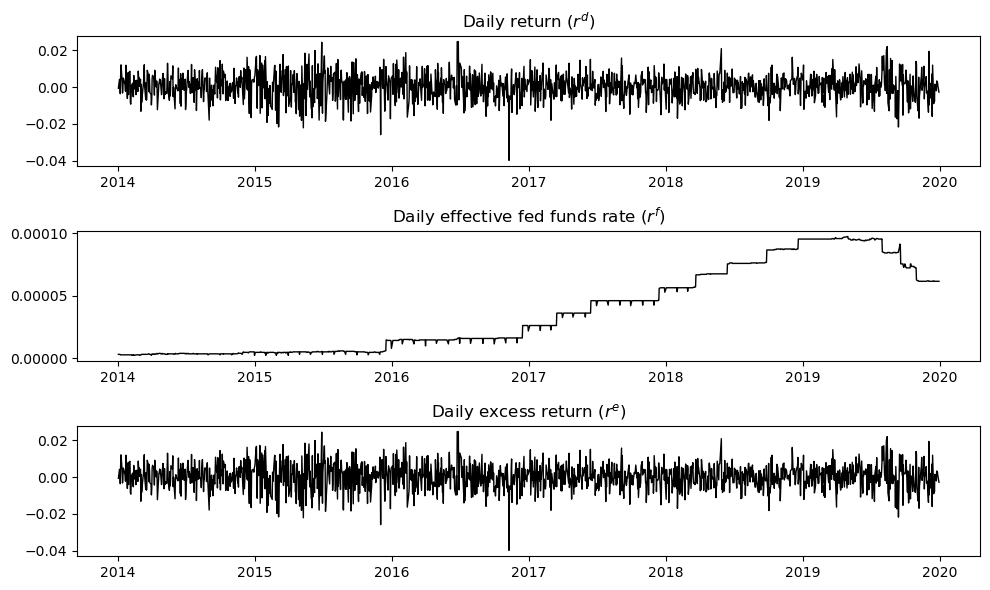

In [37]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: Mean Rversion Strategy

[0.97463008 0.98132494 1.00259175 1.02154279 1.02874921]


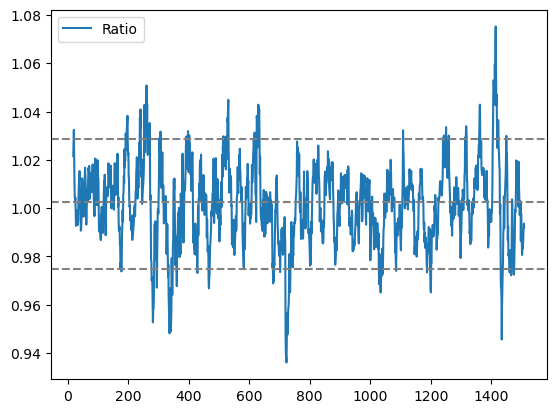

In [38]:
MA = 20
df['MA'] = df['Close'].rolling(MA).mean()
df['Ratio'] = df['Close'] / df['MA']
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
print(p)
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
df['Ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--')

In [45]:
train_set =  df.copy()
short = p[-1]
long = p[0]

train_set['Position'] = np.zeros(len(train_set))
train_set['Position'] = np.where(train_set['Ratio'] > short, -1, np.nan)
train_set['Position'] = np.where(train_set['Ratio'] < long, 1, train_set['Position'])
# train_set['Position'] = train_set['Position'].ffill()
train_set['Position'] = train_set['Position'].fillna(0)

train_set

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Ratio,Position
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,NaN,NaN,NaN,0.0
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,-0.006686,NaN,NaN,0.0
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,0.041586,NaN,NaN,0.0
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,0.033129,NaN,NaN,0.0
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,-0.036380,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100,-0.021003,39.8245,0.983314,0.0
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258,0.032582,39.7755,0.987794,0.0
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484,0.024836,39.7200,0.991692,0.0
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700,0.007001,39.6725,0.993635,0.0


In [40]:
short = p[-1]
long = p[0]
train_set['Position'] = np.where(train_set['Ratio'] > short, -1, np.nan)
train_set['Position'] = np.where(train_set['Ratio'] < long, 1, train_set['Position'])
train_set['Position'] = train_set['Position'].ffill()

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


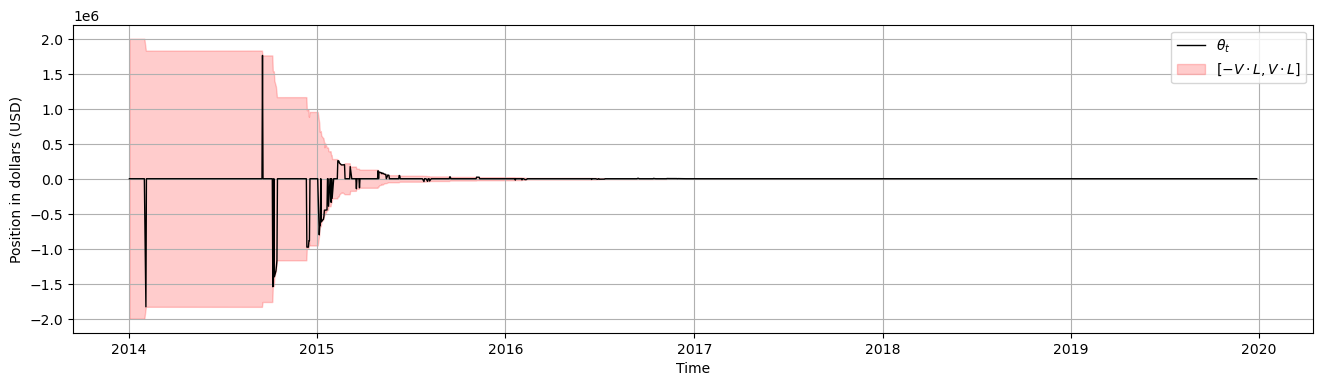

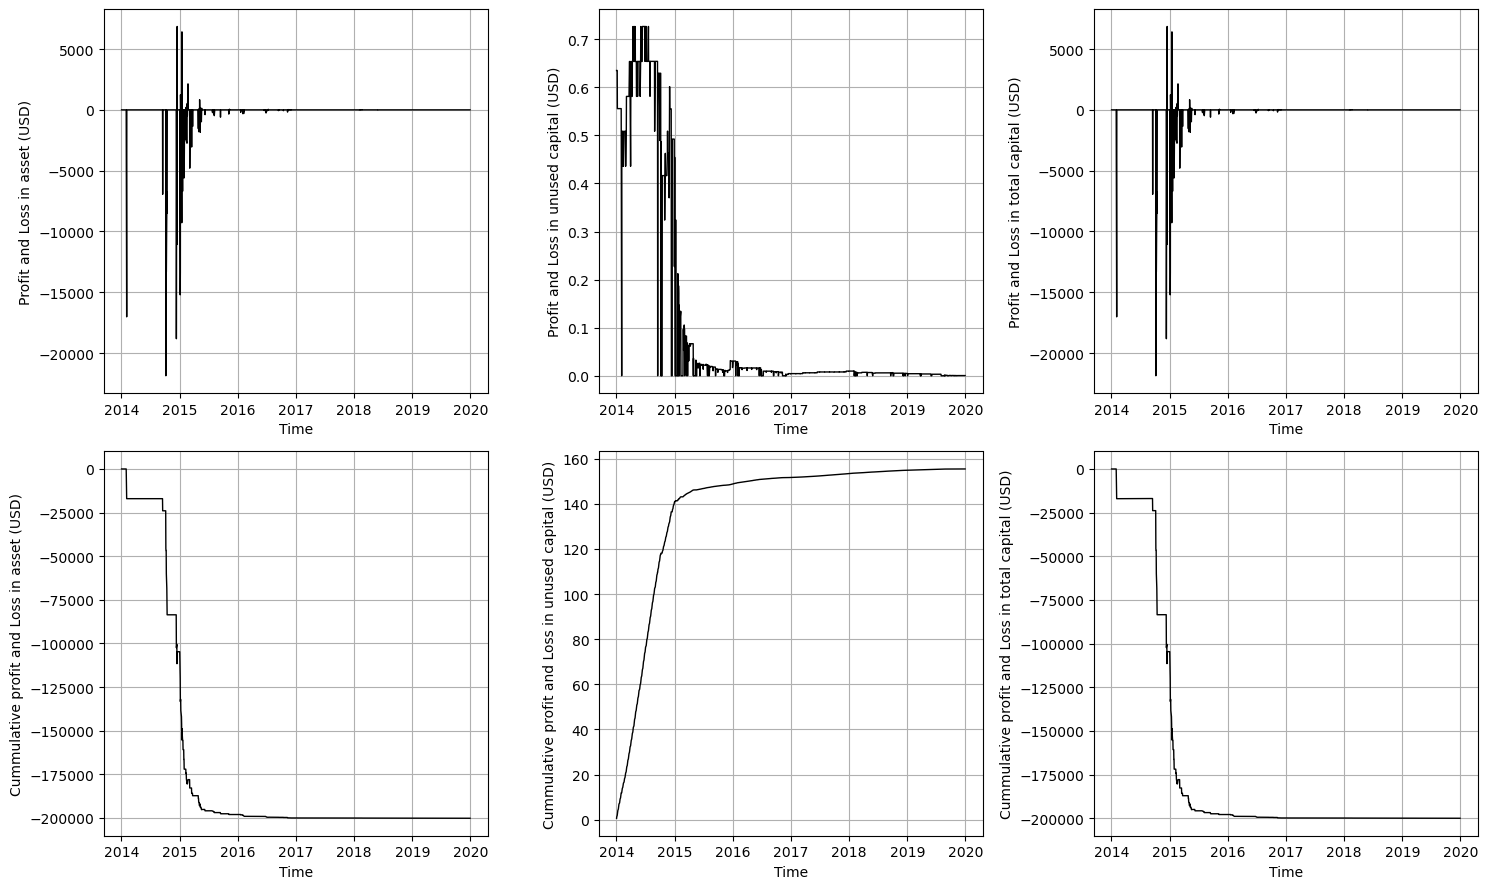

In [46]:
result_train = compute_position_value(df = train_set, 
                           signal = train_set['Position'], 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = False)

a, b = 0, -1
plot_position(train_set['Date'][a: b], result_train['theta'][a: b], result_train['Vtot'][a: b], leverage=LEVERAGE) 

plot_PnL(train_set['Date'], result_train['dV'], result_train['dVcap'], result_train['dVtot'])

In [42]:
compute_sharpe_ratio(result_test['dV'])
compute_sortino_ratio(result_test['dV'])
compute_drawdown(result_test['Vtot'], max_drawdown = True)
compute_drawdown(result_test['Vtot'], max_drawdown= False)
compute_calmar_ratio(result_test['dV'], result_test['V'])

NameError: name 'result_test' is not defined

In [ ]:
print(f"Sharpe ratio: {compute_sharpe_ratio(result_test['dV'])}")
print(f"Sortino ratio: {compute_sortino_ratio(result_test['dV'])}")
print(f"Max drawdown: {compute_drawdown(result_test['Vtot'], max_drawdown = True)}")
print(f"Calmer ratio: {compute_calmar_ratio(result_test['dV'], result_test['Vtot'])}")


Sharpe ratio: 0.1405843178568042
Sortino ratio: 0.15491167762655103
Max drawdown: 0.059804994362371786
Calmer ratio: 14721.0365875777


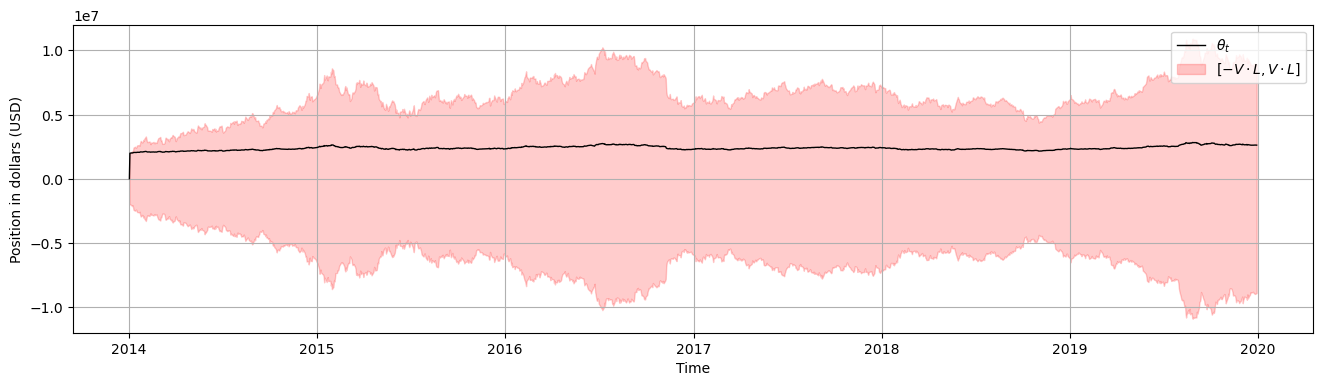

In [ ]:
buy_and_hold_signal = np.zeros(len(df))
buy_and_hold_signal[1] = 1

result = compute_position_value(df = df, 
                           signal = buy_and_hold_signal, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)
plot_position(df['Date'], result['theta'], result['Vtot'], leverage=LEVERAGE) 

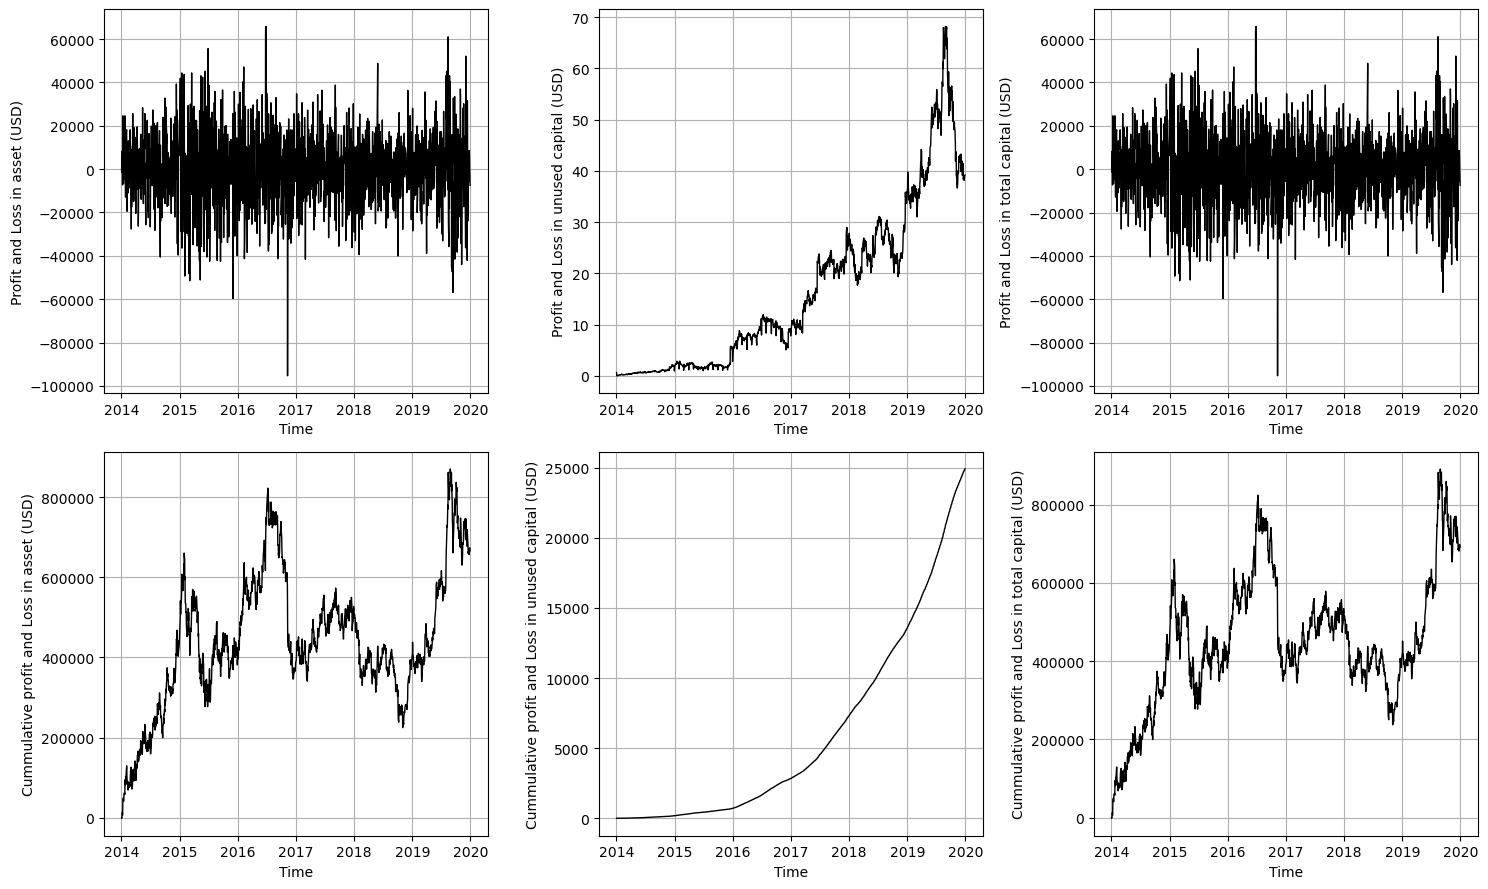

In [ ]:
plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])